Swin Transformers
This notebook trains a Vision Transformer on Alzheimer_s Dataset.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# We use Alzheimer_s Dataset to demonstrate the classification method

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torchvision
from torchvision import datasets
from torchvision import models
from torchvision import transforms as T# for simplifying the transforms
from torch import nn, optim
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, sampler, random_split
import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss


In [3]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import sys
from tqdm import tqdm
import time
import copy

In [6]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [7]:
def get_data_loaders(data_dir, batch_size, batch_size_test,train_percentage=0.8):
    # Define data transformations
    transform = T.Compose([
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD),
        T.RandomErasing(p=0.1, value='random')
    ])

    # Load the entire dataset
    full_dataset = datasets.ImageFolder(data_dir, transform=transform)

    # Calculate the number of samples for train, validation, and test
    total_samples = len(full_dataset)
    train_size = int(train_percentage * total_samples)
    test_size = total_samples - train_size 

    # Split the dataset
    train_dataset, test_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, test_size])

    # Create DataLoader for each split
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True, num_workers=4)

    return train_loader, test_loader

In [8]:
dataset_path ="/kaggle/input/fdata-adni-dataset/AugmentedAlzheimerDataset"

In [9]:
train_loader, test_loader = get_data_loaders(dataset_path , batch_size=64,batch_size_test=32)

In [10]:
classes = get_classes("/kaggle/input/fdata-adni-dataset/AugmentedAlzheimerDataset")
print(classes, len(classes))

['AD', 'CN', 'EMCI', 'LMCI'] 4


In [11]:
dataloaders = {
    "train": train_loader,
    "test": test_loader,
}

dataset_sizes = {
    "train": len(train_loader.dataset),
    "test": len(test_loader.dataset),
}

In [12]:
print(len(train_loader), len(test_loader))

425 213


In [13]:
print(len(train_loader.dataset),
     len(test_loader.dataset))

27187 6797


In [14]:
# now, for the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [15]:
# Load the pre-trained Swin Transformer model
HUB_URL = "SharanSMenon/swin-transformer-hub:main"
MODEL_NAME = "swin_tiny_patch4_window7_224"
# check hubconf for more models.
swin_model = torch.hub.load(HUB_URL, MODEL_NAME, pretrained=True)

# Freeze Swin Transformer model parameters
for param in swin_model.parameters():
    param.requires_grad = False

# Modify the head of the Swin Transformer model
n_inputs = swin_model.head.in_features
swin_model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(classes))
)
swin_model = swin_model.to(device)
print(swin_model.head)

Downloading: "https://github.com/SharanSMenon/swin-transformer-hub/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_tiny_patch4_window7_224.pth" to /root/.cache/torch/hub/checkpoints/swin_tiny_patch4_window7_224.pth
100%|██████████| 109M/109M [00:00<00:00, 305MB/s] 


Sequential(
  (0): Linear(in_features=768, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=4, bias=True)
)


In [16]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.AdamW(swin_model.head.parameters(), lr=0.001)

In [17]:
# lr scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [18]:
import time
import copy
from tqdm import tqdm

def train_model(swin_model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()
    best_model_wts = copy.deepcopy(swin_model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)

        for phase in ['train']:
            if phase == 'train':
                swin_model.train()  # Set model to training mode
            else:
                swin_model.eval()   # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = swin_model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            if phase == 'train' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(swin_model.state_dict())

        # Learning rate scheduler step placed here
        scheduler.step()

    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best Acc: {:.4f}".format(best_acc))

    swin_model.load_state_dict(best_model_wts)
    return swin_model

In [19]:
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

In [20]:
# Load a pre-trained ResNet50 model
resnet_model = timm.create_model("resnet50", pretrained=True)

# Modify the head of the ResNet50 model
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(classes))
)

# Define an ensemble model that combines both models
class Ensemble(nn.Module):
    def __init__(self, model1, model2):
        super(Ensemble, self).__init__()
        self.model1 = model1
        self.model2 = model2

    def forward(self, x):
        output1 = self.model1(x)
        output2 = self.model2(x)
        output = (output1 + output2) / 2  # Average the predictions
        return output

# Create an instance of the ensemble model
ensemble_model = Ensemble(swin_model, resnet_model)

# Move the ensemble model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ensemble_model = ensemble_model.to(device)

# Define loss function and optimizer
criterion = LabelSmoothingCrossEntropy()
optimizer = optim.AdamW(ensemble_model.parameters(), lr=0.001, weight_decay=1e-5)

# Train the ensemble model
ensemble_model = train_model(ensemble_model, criterion, optimizer, exp_lr_scheduler, num_epochs=1)

# Evaluate the ensemble model
test_accuracy = evaluate_model(ensemble_model, test_loader)
print("Test Accuracy of the Ensemble Model:", test_accuracy)

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Epoch 0/0
----------


100%|██████████| 425/425 [03:23<00:00,  2.09it/s]

train Loss: 0.8571 Acc: 0.6935
Training complete in 3m 23s
Best Acc: 0.6935


Test Accuracy of the Ensemble Model: 0.7902015595115492


Epoch [1/2], Train Loss: 0.5678, Train Acc: 0.8856
Epoch [2/2], Train Loss: 0.4527, Train Acc: 0.9506


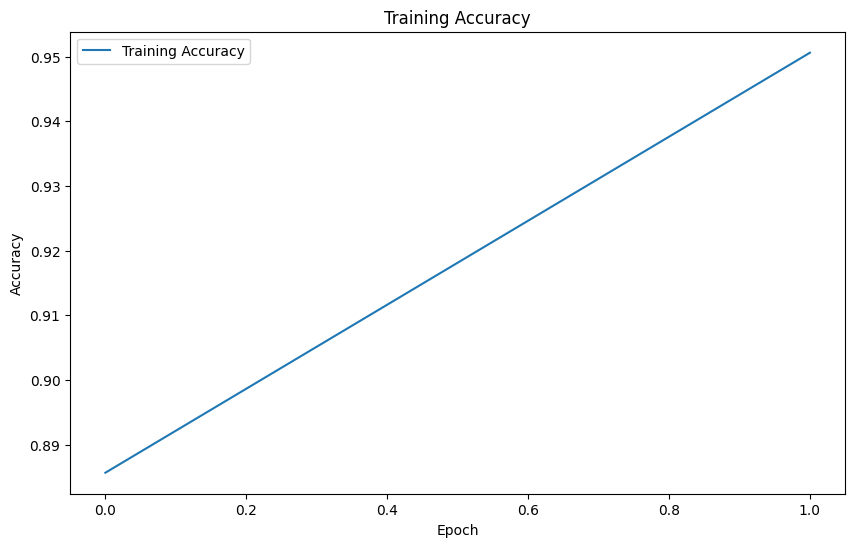

In [21]:
# Lists to store training accuracy
train_acc_history = []

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    for epoch in range(num_epochs):
        # Train phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct_train / total_train
        train_acc_history.append(epoch_train_acc)

        # Print training loss and accuracy
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}')
        
        # Update learning rate
        scheduler.step(epoch_train_loss)
    
    return model

# Train the ensemble model
ensemble_model = train_model(ensemble_model, criterion, optimizer, exp_lr_scheduler, num_epochs=2)

# Plotting the training accuracy graph
plt.figure(figsize=(10, 6))
plt.plot(train_acc_history, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(False)
plt.show()


Epoch [1/2], Train Loss: 0.4203, Train Acc: 0.9681
Epoch [2/2], Train Loss: 0.4037, Train Acc: 0.9772


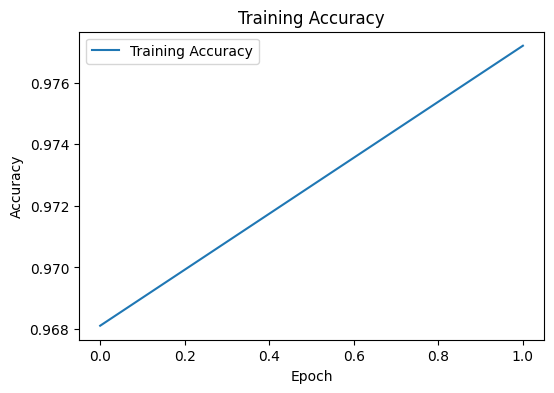

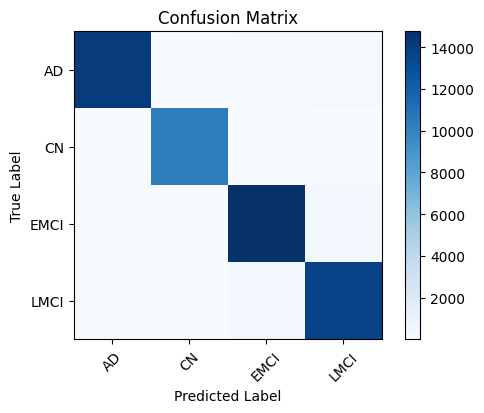

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Lists to store training accuracy and labels
train_acc_history = []
predicted_labels = []
true_labels = []

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    for epoch in range(num_epochs):
        # Train phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            # Collect predicted and true labels
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct_train / total_train
        train_acc_history.append(epoch_train_acc)

        # Print training loss and accuracy
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}')
        
        # Update learning rate
        scheduler.step(epoch_train_loss)
    
    return model

# Train the ensemble model
ensemble_model = train_model(ensemble_model, criterion, optimizer, exp_lr_scheduler, num_epochs=2)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plotting the training accuracy graph
plt.figure(figsize=(6,4))
plt.plot(train_acc_history, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(False)
plt.show()

# Plotting the confusion matrix
plt.figure(figsize=(6, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## Testing

Ok, now we finished training. Lets run the dataset on the test loader and calculate accuracy

In [23]:
test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
ensemble_model.eval()

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output = ensemble_model(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss / len(test_loader.dataset)
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
       
        print("Test accuracy of %s: NA" % (classes[i]))
print("Test Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        )) 

100%|██████████| 213/213 [00:29<00:00,  7.15it/s]

Test Loss: 0.0007
Test Accuracy of    AD: 96% (1734/1793)
Test Accuracy of    CN: 99% (1285/1288)
Test Accuracy of  EMCI: 94% (1827/1934)
Test Accuracy of  LMCI: 94% (1673/1769)
Test Accuracy of 96% (6519/6784)


our model earns 97% test accuracy, which is very high. let's save it!

In [24]:
# example = torch.rand(1, 3, 224, 224)
# traced_script_module = torch.jit.trace(ensemble_model.cpu(), example)
# traced_script_module.save("/kaggle/working/alzahimer_ensemble_model.pt")

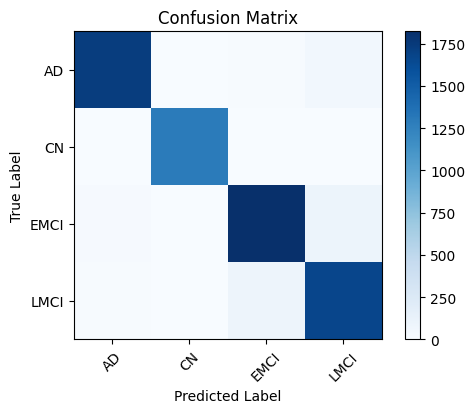

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you have the test data and labels loaded into 'test_data' and 'true_labels'

# Set the ensemble model to evaluation mode
ensemble_model.eval()

# Initialize lists to store predicted labels and true labels
predicted_labels = []
true_labels = []

# Iterate over the test data and make predictions
for data, labels in test_loader:
    data = data.to(device)
    with torch.no_grad():
        outputs = ensemble_model(data)
    _, predicted = torch.max(outputs, 1)
    predicted_labels.extend(predicted.cpu().numpy())
    true_labels.extend(labels.numpy())

# Convert lists to numpy arrays
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
